# Section 2.3.3: Nnet-survival Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement Nnet-survival (Gensheimer and Narasimhan, 2019) using PyCox and PyTorch. For an overview of Nnet-survival, please see Example 2.3.2 in Section 2.3.3 of the monograph. This demo is very similar to the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`). Please look at the DeepHit demo first. In PyCox, Nnet-survival is implemented in the `LogisticHazard` Python class.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

Time discretization works in the exact same way as in the DeepHit demo.

In [3]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at the time of writing, the code is a bit picky about the data types used. When evaluating the loss later, the underlying PyCox code needs the event indicators to be cast as float32 (unlike in the DeepHit demo).

In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.float32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.float32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the Nnet-survival model and loss

In [5]:
import torch.nn as nn
from pycox.models import LogisticHazard

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, output_num_time_steps)).to(device)

nnetsurvival_model = LogisticHazard(base_neural_net, device=device,
                                    duration_index=time_grid_train_np)
nnetsurvival_loss = nnetsurvival_model.loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [6]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = nnetsurvival_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += nnetsurvival_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += nnetsurvival_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 4.968472003936768 - val loss 4.938335418701172
Epoch 2 - train loss 3.9977524280548096 - val loss 3.996711015701294
Epoch 3 - train loss 3.8446109294891357 - val loss 3.8548760414123535
Epoch 4 - train loss 3.7577919960021973 - val loss 3.783118486404419
Epoch 5 - train loss 3.6902425289154053 - val loss 3.723034143447876
Epoch 6 - train loss 3.641087055206299 - val loss 3.6811790466308594
Epoch 7 - train loss 3.606241226196289 - val loss 3.652308225631714
Epoch 8 - train loss 3.58150577545166 - val loss 3.6336753368377686
Epoch 9 - train loss 3.564034938812256 - val loss 3.6228458881378174
Epoch 10 - train loss 3.550889015197754 - val loss 3.6081132888793945
Epoch 11 - train loss 3.540579319000244 - val loss 3.6052191257476807
Epoch 12 - train loss 3.5329127311706543 - val loss 3.59692645072937
Epoch 13 - train loss 3.525728464126587 - val loss 3.5962717533111572
Epoch 14 - train loss 3.520026922225952 - val loss 3.593959093093872
Epoch 15 - train loss 3.513835430

<All keys matched successfully>

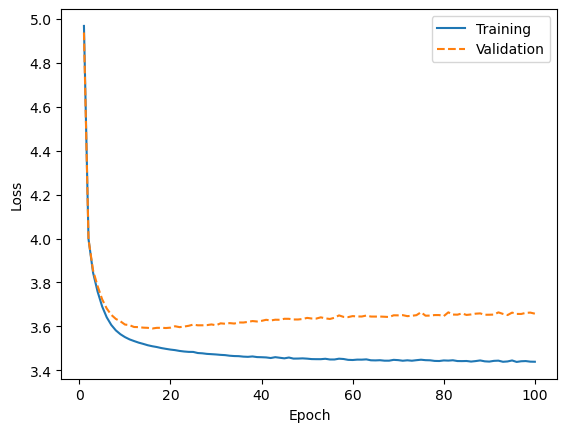

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

The code here is basically the same as in the DeepHit demo.

In [8]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

We compute interpolated survival curves for the test set.

In [9]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = nnetsurvival_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

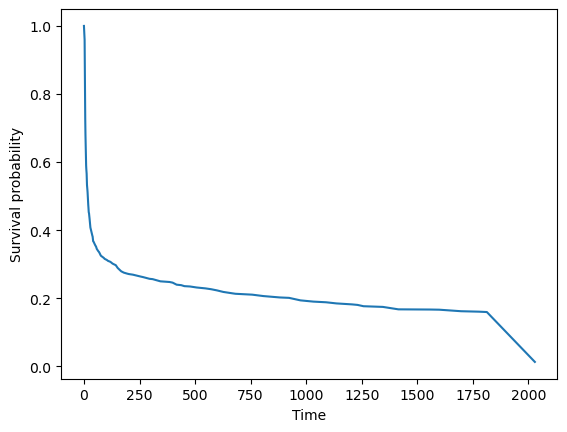

In [10]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [11]:
test_time_grid_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [12]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6058812636424377


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [13]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(test_time_grid_np)),
                     int(.5 * len(test_time_grid_np)),
                     int(.75 * len(test_time_grid_np))]

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5949681743892252
Eval time 693.0 - truncated time-dependent concordance: 0.5971409048872542
Eval time 1291.0 - truncated time-dependent concordance: 0.5961824163352452


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [14]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6511213558211291
Eval time 693.0 - time-dependent AUC: 0.684395583439373
Eval time 1291.0 - time-dependent AUC: 0.6791619083734639


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [15]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(test_time_grid_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.23204116850921025
Eval time 693.0 - Brier score: 0.20919962835759953
Eval time 1291.0 - Brier score: 0.19076235401204092
Integrated Brier score: 0.19155566452236197


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [16]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [17]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 615.1273008931904


In [18]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 733.1180280653864
